In [1]:
import models.icsn as icsn

In [8]:
# change working directory to this path
# C:\Users\yuviu\Desktop\Uni Work\Thesis\XIConceptLearning


In [1]:
import os
import torch
import pickle
from torchvision import transforms
import numpy as np
from torch.utils.data import Dataset
os.chdir(r'C:\Users\yuviu\Desktop\Uni Work\Thesis\XIConceptLearning')


def get_dataloader(config):
    print(f"Getting dataloader for {config['dataset']}")
    dataset = load_data(config)
    return torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'],
                                       shuffle=True, num_workers=config['n_workers'], pin_memory=True)

def load_data(config):
    print('Loading data...')
    print('Dataset: {}'.format(config['dataset']))
    # dataloader setup
    if config['dataset'] == 'ecr':
        dataset = ECR_PairswithTest(config['data_dir'], attrs='')
        config['img_shape'] = (3, 64, 64)
        return dataset
    elif config['dataset'] == 'ecr_spot':
        dataset = ECR_PairswithTest(config['data_dir'],
                                            attrs='_spot')
        config['img_shape'] = (3, 64, 64)
        return dataset
    elif config['dataset'] == 'ecr_nospot':
        dataset = ECR_PairswithTest(config['data_dir'],
                                            attrs='_nospot')
        config['img_shape'] = (3, 64, 64)
        return dataset
    elif config['dataset'] == 'dsprites':
        dataset = DSpritesDataset(config['data_dir'], mode=config.get('mode', 'train'))
        config['img_shape'] = (1, 64, 64)
        return dataset
        
    else:
        raise ValueError('Select valid dataset please')


def get_test_set(data_loader, config):

    x = data_loader.dataset.test_data
    y = data_loader.dataset.test_labels.tolist()
    y = [sample[0] for sample in y]
    y_set = np.unique(y, axis=0).tolist()
    x_set = []
    for u in y_set:
        x_set.append(np.moveaxis(x[y.index(u)][0], (0, 1, 2), (1, 2, 0)))
    x_set = torch.Tensor(x_set)
    x_set = x_set.to(config['device'])

    y_set = torch.tensor(y_set)
    return x_set, y_set


class ECR_PairswithTest(Dataset):
    def __init__(self, root, attrs, mode='train', single=False):
        self.root = root
        self.single_imgs = single
        assert os.path.exists(root), 'Path {} does not exist'.format(root)

        print("Loading " + os.path.sep.join([root, f"train_ecr{attrs}_pairs.npy"]))

        self.train_data_path = os.path.sep.join([root, mode, f"{mode}_ecr{attrs}_pairs.npy"])
        self.test_data_path = os.path.sep.join([root, "test", f"test_ecr{attrs}_pairs.npy"])
        self.train_labels_path = os.path.sep.join([root, mode, f"{mode}_ecr{attrs}_labels_pairs.pkl"])
        self.test_labels_path = os.path.sep.join([root, "test", f"test_ecr{attrs}_labels_pairs.pkl"])

        self.train_data = np.load(self.train_data_path, allow_pickle=True)
        self.test_data = np.load(self.test_data_path, allow_pickle=True)

        self.train_data = (self.train_data - self.train_data.min()) / (self.train_data.max() - self.train_data.min())
        self.test_data = (self.test_data - self.test_data.min()) / (self.test_data.max() - self.test_data.min())

        with open(self.train_labels_path, 'rb') as f:
            labels_dict = pickle.load(f)
            self.train_labels = labels_dict['labels_one_hot']
            self.train_labels_as_id = labels_dict['labels']
            try:
                self.shared_labels = labels_dict['shared_labels']
            except:
                self.shared_labels = None
        with open(self.test_labels_path, 'rb') as f:
            labels_dict = pickle.load(f)
            self.test_labels = labels_dict['labels_one_hot']

    def __getitem__(self, index):
        imgs = self.train_data[index]

        labels_one_hot = self.train_labels[index]
        labels_ids = self.train_labels_as_id[index]

        # compute which category is shared unless it was precomputed
        if self.shared_labels is not None:
            shared_labels = self.shared_labels[index].astype(np.bool_)
        else:
            shared_labels = (labels_ids[0] == labels_ids[1])

        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
        ])

        # transform the positive negative samples
        img0 = transform(np.uint8(imgs[0]*255)).float()
        img1 = transform(np.uint8(imgs[1]*255)).float()
        # img_size = tuple(img0.shape[-2:])

        if self.single_imgs:
            return torch.cat((img0, img1), dim=0), torch.cat((labels_one_hot[0], labels_one_hot[1]), dim=0), \
                   torch.cat((labels_ids[0], labels_ids[1]), dim=0)
        else:
            return (img0, img1), (labels_one_hot[0], labels_one_hot[1]), (labels_ids[0], labels_ids[1]), shared_labels

    def __len__(self):
        return len(self.train_data)
    
class DSpritesDataset(Dataset):
    def __init__(self, root, mode='train'):
        self.root = root
        assert os.path.exists(root), 'Path {} does not exist'.format(root)

        with np.load(f'{self.root}/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', allow_pickle=True, encoding='latin1') as data:
            self.imgs = data['imgs']
            self.latents_values = data['latents_values']
            self.latents_classes = data['latents_classes']
        # split the dataset into train and test sets
        if mode == 'train':
            self.imgs = self.imgs[:60000]  # first 60000 images as train set
            self.latents_values = self.latents_values[:60000]
        else:
            self.imgs = self.imgs[60000:]  # remaining images as test set
            self.latents_values = self.latents_values[60000:]

        self.imgs = self.imgs[:, np.newaxis, :, :]  # add an extra dimension for the single channel (grayscale)

    def __getitem__(self, index):
        img = self.imgs[index]
        img = img.astype(np.float32) / 255.0  # normalize pixel values to [0, 1]
        img = torch.from_numpy(img)

        latents = self.latents_values[index]
        latents = torch.from_numpy(latents)

        return img, latents

    def __len__(self):
        return len(self.imgs)





Args

In [2]:
import os
import argparse
import torch
import json
import datetime
import numpy as np
from utils import set_seed, makedirs


# parse train options
def _get_parser():
    parser = argparse.ArgumentParser()

    parser.add_argument('--device', type=str, default='cuda', help='device to be used')
    parser.add_argument('--device-ids', type=int, nargs='+', default=[0], help='device to be used')

    # parser.add_argument('--learn', type=str, required=True, help='unsup, weakly or sup')

    parser.add_argument('--save-step', type=int, default=50, help='save model every # steps')
    parser.add_argument('--print-step', type=int, default=10, help='print metrics every # steps')
    parser.add_argument('--display-step', type=int, default=1,
                        help='track metrics and iamges on tensorboard every # steps')

    # parser.add_argument('--lambda-recon-z', type=float, default=0., help='lambda for z recon loss')
    parser.add_argument('--lambda-recon-proto', type=float, default=1.,
                        help='lambda for agg prototype recon loss')
    parser.add_argument('--lambda-rr', type=float, default=1.,
                        help='lambda for rigth reason mse loss')
    parser.add_argument('--train-protos', action='store_true', help='should the prototype embedding weights be updated '
                                                                    'too?')
    parser.add_argument('--freeze-enc', action='store_true', help='should the encoder be further finetuned or not')

    parser.add_argument('-lr', '--learning-rate', type=float, default=1e-3, help='learning rate')
    parser.add_argument('--lr-scheduler', action='store_true', help='use learning rate scheduler')
    parser.add_argument('--lr-scheduler-warmup-steps', type=int, default=0,
                        help='learning rate scheduler warmup steps')
    parser.add_argument('-bs', '--batch-size', type=int, default=500, help='batch size, for paired training this is '
                                                                           'the batch size of pairs, so in the end you '
                                                                           'have 2xbs')
    parser.add_argument('-e', '--epochs', type=int, default=500, help='Number of epochs to train for')
    parser.add_argument('--n-workers', type=int, default=1, help='workers to load data')

    parser.add_argument('-pv', '--prototype-vectors', type=int , nargs='+', default=[2, 3],
                        help='List of number of prototype vectors per category [#p1, #p2, ...]')
    parser.add_argument('--n-protos', type=int, default=2,
                        help='number of classes per categorical variable, i.e. number of prototypes per group')
    parser.add_argument('--proto-dim', type=int, default=32, help='dimensions of each prototype')
    parser.add_argument('--extra-mlp-dim', type=int, default=4, help='dimensions of extra mlp')
    parser.add_argument('--multiheads', action='store_true',
                        help='should multiple mlp heads be used each for one category??')

    parser.add_argument('--lin-enc-size', type=int, default=512, help='latent dimensions')
    parser.add_argument('--temperature', type=float, default=1., help='temperature of gumbel softmax')

    parser.add_argument('--exp-name', type=str, default='', help='experiment name')
    parser.add_argument('--results-dir', type=str, default='results', help='results directory')
    parser.add_argument('--model-dir', type=str, default='states', help='model directory')
    parser.add_argument('--img-dir', type=str, default='imgs', help='image\plot directory')
    parser.add_argument('-dd', '--data-dir', type=str, default='Data/ECR', help='data directory')

    parser.add_argument('-s', '--seed', type=int, default=42, help='seed')

    parser.add_argument('-d', '--dataset', type=str, default='toycolor',
                        help="'toycolor' or 'mnist' or 'toycolorshape' or 'toyshapesize' or 'toycolorshapesize'")
    parser.add_argument('--initials', type=str, required=False,
                        help="Your initials")
    parser.add_argument('--fpath-load-pretrained', type=str, default=None,
                        help='specify the fpath to the pretrained model')
    parser.add_argument('--ckpt-fp', type=str, default=None,
                        help='file path to ckpt file from which to continue training')
    parser.add_argument('--test', action='store_true', help='should we just test?')
    parser.add_argument('--wrong-protos', type=int, nargs='+', action='append', default=None,
                        help='List of list of prototypes to ignore, e.g. 0, 2 for the first group. Please repeat the '
                             'args for each further group, e.g. --wrong-protos 0 2 --wrong-protos 2 4 for a final '
                             'list[[0,2], [2,4]]' )
    parser.add_argument('--pent-id', type=int, default=None, help='which prototype should encode the pentagon shape?')
    parser.add_argument('--circle-id', type=int, default=None, help='which prototype should encode the circle shape?')

    return parser


def parse_args(argv):
    """Parses arguments passed from the console as, e.g.
    'python ptt/main.py --epochs 3' """

    parser = _get_parser()
    args = parser.parse_args(argv)

    #args.prototype_vectors = [int(n) for n in args.prototype_vectors[0].split(',')]
    # args.n_prototype_groups = len(args.prototype_vectors)
    if args.exp_name == '':
        args.exp_name = 'seed' + str(args.seed) + '_' \
                        + 'protos' + str(args.prototype_vectors) + '_' + \
                        str(datetime.datetime.now()).replace(' ', '_').replace(':', '-').split('.')[0]

    args.results_dir = os.path.join(args.results_dir, args.exp_name)
    args.model_dir = os.path.join(args.results_dir, args.model_dir)
    args.img_dir = os.path.join(args.results_dir, args.img_dir)
    makedirs(args.model_dir)
    makedirs(args.img_dir)

    # set seed for all random processes
    set_seed(args.seed)

    args.device = str(
        args.device + ':' + str(args.device_ids[0]) if torch.cuda.is_available() and args.device == "cuda" else "cpu")
    device_name = str(torch.cuda.get_device_name(args.device) if args.device == "cuda" else args.device)
    print('Device name: {}'.format(device_name))

    args.n_groups = len(args.prototype_vectors)

    # turn list of list into one list with cumulated ids, e.g. [[0, 2], [1, 3]] --> [0, 2, 7, 9] for two groups
    # of 6 prototype vectors
    if args.wrong_protos is not None:
        tmp = []
        pv_cumsum = np.insert(np.cumsum(args.prototype_vectors), 0, 0)
        for i in range(len(args.prototype_vectors)):
            tmp.extend(list((args.wrong_protos[i] + pv_cumsum[i]).astype(int)))
        args.wrong_protos = [int(elem) for elem in tmp]

    with open(os.path.join(args.results_dir, 'args.json'), 'w') as json_file:
        json.dump(vars(args), json_file, indent=2)

    return args


def parse_args_as_dict(argv):
    """Parses arguments passed from the console and returns a dictionary """
    return vars(parse_args(argv))


def parse_dict_as_args(dictionary):
    """Parses arguments given in a dictionary form"""
    argv = []
    for key, value in dictionary.items():
        if isinstance(value, bool):
            if value:
                argv.append('--' + key)
        else:
            argv.append('--' + key)
            argv.append(str(value))
    return parse_args(argv)


In [3]:
config = parse_args_as_dict(['--initials', 'test', 
                             '-dd', 'Data/dsprites',
                             '-d', 'dsprites'])

Device name: cuda:0


In [17]:
_data_loader = get_dataloader(config)


Getting dataloader for dsprites
Loading data...
Dataset: dsprites


Device name: cuda:0
Getting dataloader for dsprites
Loading data...
Dataset: dsprites
Images shape: torch.Size([64, 1, 64, 64])
Latents shape: torch.Size([64, 6])


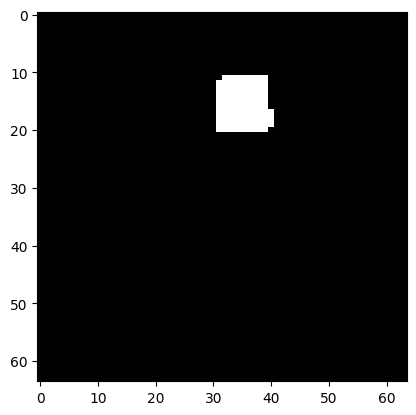

In [4]:

def test_dataloader():
    config = parse_args_as_dict(['--initials', 'test', 
                                 '-dd', 'Data/dsprites',
                                 '-d', 'dsprites',
                                 '-bs', '64', 
                                 '--n-workers', '0'])

    dataloader = get_dataloader(config)

    
    return dataloader

dataloader = test_dataloader()
# Load a batch of data
data_iter = iter(dataloader)
images, latents = next(data_iter)

print(f'Images shape: {images.shape}')
print(f'Latents shape: {latents.shape}')

# Optionally, display an image
import matplotlib.pyplot as plt
plt.imshow(images[0].squeeze(), cmap='gray')
plt.show()

In [48]:
print(f'Latents[0]: {latents[0]}')


Latents[0]: tensor([1.0000, 1.0000, 0.5000, 3.2221, 0.6129, 0.0000], dtype=torch.float64)


In [13]:
print(f'One hot shape: {one_hot.shape}')
print(f'One hot[0]: {one_hot[0]}')

One hot shape: torch.Size([64, 6])
One hot[0]: tensor([0., 0., 0., 0., 0., 0.])


In [17]:
def test_dataloader_ecr():
    config = parse_args_as_dict(['--initials', 'test', 
                                 '-dd', 'Data/ECR',
                                 '-d', 'ecr',
                                 '-bs', '64', 
                                 '--n-workers', '0'])

    dataloader = get_dataloader(config)

    
    return dataloader

dataloader_ecr = test_dataloader_ecr()


Device name: cuda:0
Getting dataloader for ecr
Loading data...
Dataset: ecr
Loading Data/ECR\train_ecr_pairs.npy


In [49]:
for i, (imgs, labels_one_hot, labels_id, shared_labels) in enumerate(dataloader_ecr):
        # imgs is a list
        print(f"imgs[0].shape {imgs[0].shape}")
        print(f"imgs[1].shape {imgs[1].shape}")
        print(f"labels_one_hot[0].shape {labels_one_hot[0].shape}")
        print(f"labels_one_hot[1].shape {labels_one_hot[1].shape}")
        print(f"labels_id[0].shape {labels_id[0].shape}")
        print(f"labels_id[1].shape {labels_id[1].shape}")
        print(f"shared_labels.shape {shared_labels.shape}")
        break

imgs[0].shape torch.Size([64, 3, 64, 64])
imgs[1].shape torch.Size([64, 3, 64, 64])
labels_one_hot[0].shape torch.Size([64, 10])
labels_one_hot[1].shape torch.Size([64, 10])
labels_id[0].shape torch.Size([64, 3])
labels_id[1].shape torch.Size([64, 3])
shared_labels.shape torch.Size([64, 3])


In [ ]:
# Load a batch of data
data_iter_ecr = iter(dataloader_ecr)
images_ecr, labels_one_hot, labels_id, shared_labels = next(data_iter_ecr)


len Images shape: 2
Images shape: torch.Size([64, 3, 64, 64])


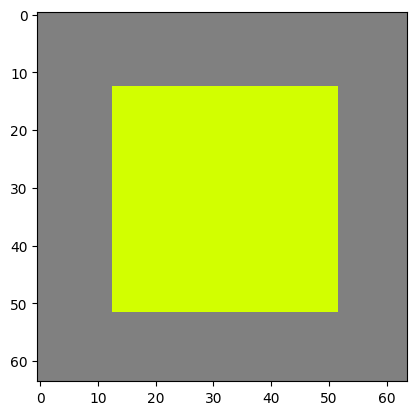

In [50]:

print(f'len Images shape: {len(images_ecr)}')
print(f'Images shape: {images_ecr[0].shape}')
# plot using matplotlib
# this image has 3 channels for RGB
# images_ecr[0] has shape 64, 3, 64, 64
# plot images_ecr with shape 64, 64, 3
plt.imshow(images_ecr[1][0].permute(1, 2, 0))
# paired image is images_ecr[1][0]
plt.imshow(images_ecr[1][0].permute(1, 2, 0))


In [47]:
print((labels_one_hot[0]))
print((labels_id[0]))

tensor([[1., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 1., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 1., 0., 1., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 1.],


In [46]:
print(labels_id[0])

tensor([[0, 2, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 0],
        [0, 3, 1],
        [3, 2, 0],
        [3, 1, 0],
        [3, 0, 1],
        [1, 0, 1],
        [3, 2, 1],
        [3, 2, 1],
        [3, 2, 0],
        [0, 1, 1],
        [3, 2, 1],
        [2, 2, 1],
        [0, 2, 1],
        [1, 1, 0],
        [1, 1, 1],
        [2, 3, 1],
        [2, 0, 1],
        [3, 0, 1],
        [0, 2, 0],
        [2, 2, 1],
        [1, 3, 0],
        [0, 3, 0],
        [2, 3, 1],
        [1, 3, 1],
        [3, 3, 1],
        [0, 1, 1],
        [0, 1, 0],
        [0, 3, 1],
        [1, 0, 0],
        [1, 0, 0],
        [2, 0, 0],
        [0, 1, 0],
        [3, 1, 1],
        [0, 1, 0],
        [1, 3, 1],
        [2, 2, 1],
        [0, 0, 1],
        [1, 0, 0],
        [3, 3, 0],
        [1, 3, 0],
        [3, 0, 0],
        [1, 2, 1],
        [3, 0, 0],
        [1, 2, 1],
        [3, 0, 1],
        [3, 1, 0],
        [2, 3, 0],
        [2, 3, 1],
        [1, 0, 0],
        [3, 

In [ ]:
fig, axs = plt.subplots(10, 10, figsize=(15, 15))
for i, ax in enumerate(axs.flat):
    ax.imshow(images_ecr[i][0])
    ax.axis('off')
    ax.set_title(f"Labels: \n{train_labels['labels'][0][0]}")